In [1]:
# 📦 Imports
import os, random, yaml, logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from data_loader import load_stock_data
from indicators import add_indicators
from preprocessing import normalize_features, df_to_windowed_df, windowed_df_to_date_X_y
from model import build_cnn_model
from evaluation import (
    plot_predictions, compute_metrics, compute_directional_accuracy,
    evaluate_multi_horizon_accuracy, evaluate_directional_accuracy_by_horizon,
    simulate_pnl
)
from feature_analysis import feature_drop_analysis
from evaluation_tables import create_evaluation_tables


In [2]:
# ⚙️ Load config
with open("config/config.yaml", "r") as f:
    config = yaml.safe_load(f)


In [3]:
# 🔧 Set seeds for reproducibility
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)


In [4]:
# 📂 Load stock data
tickers = config["tickers"]
dfs = load_stock_data(config["paths"]["csv_folder"], tickers)
df = dfs[0]  # Use the first ticker
df = add_indicators(df)
df.head()


,Close,Open,MACD,MACD_signal,MACD_hist,RSI,BB_upper,BB_lower
Date,,,,,,,,
2020-01-30 05:00:00,227.880005,223.110001,-0.584199,-0.317360,-0.266839,48.338391,231.371067,223.219932
2020-01-31 05:00:00,224.429993,226.490005,-0.727539,-0.399396,-0.328143,45.546965,231.330896,222.864103
2020-02-03 05:00:00,223.470001,225.479996,-0.908132,-0.501143,-0.406989,39.502532,231.482771,222.441228
2020-02-04 05:00:00,225.080002,226.149994,-0.910840,-0.583082,-0.327758,45.654891,231.464812,222.268187
2020-02-05 05:00:00,228.649994,226.910004,-0.617796,-0.590025,-0.027771,50.567300,231.644882,222.361116


In [5]:
# 🔄 Normalize features
df_scaled, scaler_X, scaler_y = normalize_features(df)
feature_cols = [c for c in df_scaled.columns if c != "Close"]
df_scaled.head()


,Open,MACD,MACD_signal,MACD_hist,RSI,BB_upper,BB_lower,Close
Date,,,,,,,,
2020-01-30 05:00:00,0.180617,0.511322,0.525795,0.460487,0.469511,0.156174,0.219185,0.204861
2020-01-31 05:00:00,0.191177,0.505744,0.521890,0.452524,0.438211,0.156043,0.218018,0.194111
2020-02-03 05:00:00,0.188021,0.498717,0.517047,0.442283,0.370435,0.156538,0.216630,0.191120
2020-02-04 05:00:00,0.190115,0.498611,0.513147,0.452574,0.439421,0.156480,0.216062,0.196136
2020-02-05 05:00:00,0.192489,0.510015,0.512817,0.491540,0.494504,0.157067,0.216367,0.207260


In [6]:
# 📈 Convert to windowed format
window_size = config["cnn"]["window_size"]
windowed_df = df_to_windowed_df(df_scaled, window_size)
dates, X, y = windowed_df_to_date_X_y(windowed_df, window_size)


In [7]:
# 🧪 Split data
q_90 = int(len(dates) * 0.90)
q_96 = int(len(dates) * 0.96)

X_train, X_val, X_test = X[:q_90], X[q_90:q_96], X[q_96:]
y_train, y_val, y_test = y[:q_90], y[q_90:q_96], y[q_96:]
dates_train, dates_val, dates_test = dates[:q_90], dates[q_90:q_96], dates[q_96:]


In [8]:
# 🧠 Build & train CNN model
model = build_cnn_model(window_size, X.shape[2])
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train, y_train, epochs=config["cnn"]["epochs"], batch_size=config["cnn"]["batch_size"], validation_data=(X_val, y_val))


Epoch 1/60


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0608 - val_loss: 0.0010
Epoch 2/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8902e-04 - val_loss: 7.2469e-04
Epoch 3/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3515e-04 - val_loss: 6.7880e-04
Epoch 4/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6496e-04 - val_loss: 6.9382e-04
Epoch 5/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2849e-04 - val_loss: 5.9913e-04
Epoch 6/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0041e-04 - val_loss: 5.1879e-04
Epoch 7/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8032e-04 - val_loss: 4.6821e-04
Epoch 8/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7282e-04 - val_loss: 4.5927e-04
Epoch 9/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7203e-04 - val_loss: 4.3715e-04
Epoch 10/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7408e-04 - val_loss: 4.3360e-04
Epoch 11/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6800e-04 - val_loss: 4.2914e-04
Epoch

In [9]:
# 💾 Save model
model_save_path = f"cnn_model_{tickers[0]}.h5"
model.save(model_save_path)


In [10]:
# 📊 Predictions (inverse transform)
train_pred = scaler_y.inverse_transform(model.predict(X_train)).flatten()
val_pred = scaler_y.inverse_transform(model.predict(X_val)).flatten()
test_pred = scaler_y.inverse_transform(model.predict(X_test)).flatten()

y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_val_orig = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


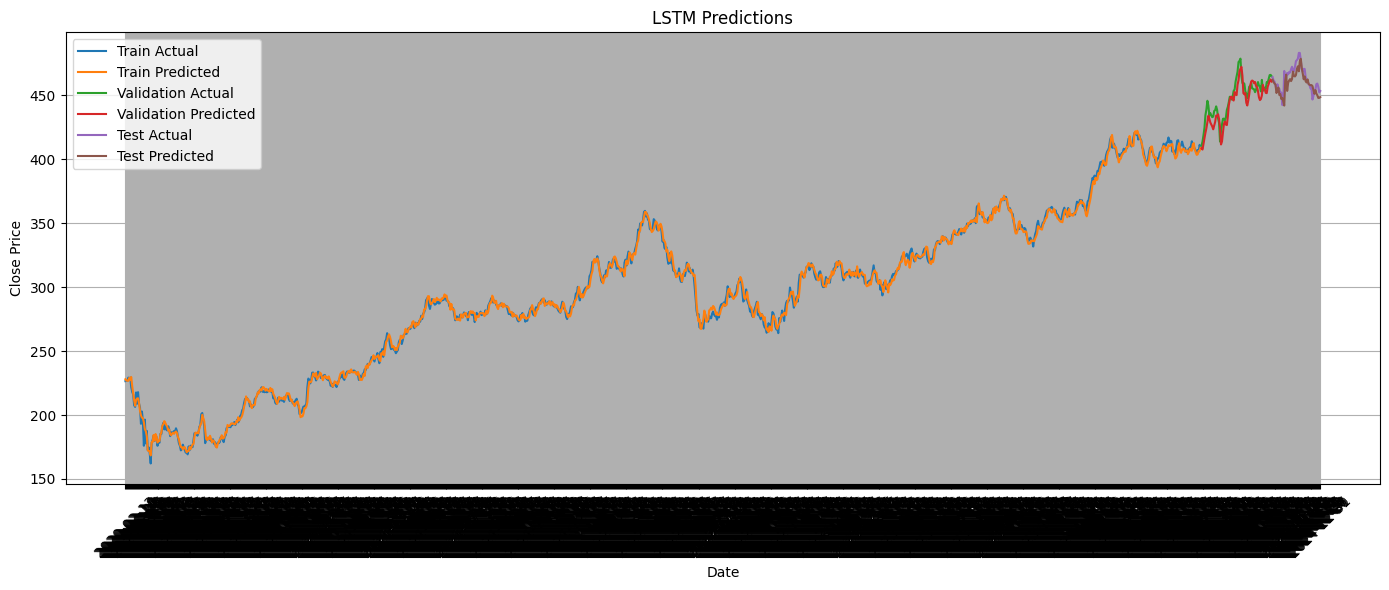

In [11]:
# 📉 Plot predictions
plot_predictions(
    dates_train, y_train_orig, train_pred,
    dates_val, y_val_orig, val_pred,
    dates_test, y_test_orig, test_pred
)


In [12]:
# 📐 Evaluate performance
rmse_test, mae_test = compute_metrics(y_test_orig, test_pred)
dir_acc_test = compute_directional_accuracy(y_test_orig, test_pred)

print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Directional Accuracy: {dir_acc_test:.4f}")


Test RMSE: 6.9205
Test MAE: 4.9847
Directional Accuracy: 0.4898


In [13]:
# 🔁 Multi-horizon evaluation
pd.DataFrame(evaluate_multi_horizon_accuracy(y_test_orig, test_pred))


,Horizon,RMSE,MAE
0,T+1,7.533686,5.644252
1,T+2,8.225451,6.435101
2,T+3,9.130621,7.187260


In [14]:
# 🚥 Directional accuracy by horizon
pd.DataFrame(evaluate_directional_accuracy_by_horizon(y_test_orig, test_pred))


,Horizon,Directional Accuracy
0,T+1,0.551020
1,T+2,0.562500
2,T+3,0.553191


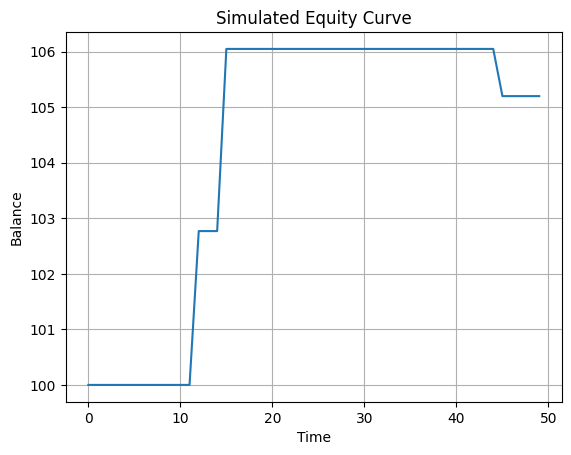

In [15]:
# 💸 PnL Simulation
balance_history, trade_log, final_balance = simulate_pnl(
    y_test_orig, test_pred, initial_balance=100.0,
    threshold=0.005, ticker=tickers[0], output_folder="output"
)

plt.plot(balance_history)
plt.title("Simulated Equity Curve")
plt.xlabel("Time")
plt.ylabel("Balance")
plt.grid(True)
plt.show()


In [16]:
# 🔬 Feature drop analysis
results_df = feature_drop_analysis(
    df_scaled, feature_cols, window_size,
    X, y, scaler_y,
    dates_test, y_test_orig,
    rmse_test, mae_test,
    q_90, q_96,
    config["cnn"]["learning_rate"],
    config["cnn"]["epochs"],
    config["cnn"]["batch_size"]
)

results_df


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/stepWARNING:tensorflow:6 out of the last 44 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001EE0EE04720> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


C:\Users\Hossein\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


,Dropped Feature,RMSE,MAE,RMSE Increase,MAE Increase
2,MACD_signal,12.513261,10.970911,5.592745,5.986229
3,MACD_hist,10.613002,8.801170,3.692486,3.816489
6,BB_lower,10.020920,8.560857,3.100404,3.576175
1,MACD,8.133611,5.618923,1.213095,0.634241
0,Open,7.841149,6.167951,0.920633,1.183270
5,BB_upper,7.419679,5.377751,0.499163,0.393069
4,RSI,5.989033,4.760964,-0.931484,-0.223718


In [17]:
# 🧾 Evaluation Tables
create_evaluation_tables(
    tickers[0], rmse_test, mae_test, dir_acc_test,
    results_df, output_folder="output"
)



🔎 Summary Metrics Table for BRK-B:
+--------+---------------------------+--------+
| Ticker |          Metric           | Value  |
+--------+---------------------------+--------+
| BRK-B  |         Test RMSE         | 6.9205 |
| BRK-B  |         Test MAE          | 4.9847 |
| BRK-B  | Test Directional Accuracy | 0.4898 |
+--------+---------------------------+--------+

📊 Feature Drop Analysis Table for BRK-B:
+--------+-----------------+--------------------+--------------------+---------------------+----------------------+
| Ticker | Dropped Feature |        RMSE        |        MAE         |    RMSE Increase    |     MAE Increase     |
+--------+-----------------+--------------------+--------------------+---------------------+----------------------+
| BRK-B  |   MACD_signal   | 12.513261398030078 | 10.970911026000977 |  5.592745286972449  |  5.986229419708252   |
| BRK-B  |    MACD_hist    | 10.613001612298769 | 8.801170349121094  | 3.6924855012411397  |  3.816488742828369   |
| BRK-

In [18]:
# 📊 Signal classification
def classify_signals(y_true, y_pred, threshold=0.005):
    signals = []
    for i in range(len(y_pred) - 1):
        pct_change = (y_pred[i+1] - y_true[i]) / y_true[i]
        if pct_change > threshold:
            signals.append("Buy")
        elif pct_change < -threshold:
            signals.append("Sell")
        else:
            signals.append("Hold")
    from collections import Counter
    return dict(Counter(signals))

classify_signals(y_test_orig, test_pred)


{'Sell': 37, 'Hold': 8, 'Buy': 4}

In [19]:
# 📅 Analyze prediction errors with dates
errors_df = pd.DataFrame({
    "Date": dates_test,
    "Actual Price": y_test_orig,
    "Predicted Price": test_pred,
    "Absolute Error": np.abs(y_test_orig - test_pred)
})

average_error = errors_df["Absolute Error"].mean()
print(f"📉 Average Absolute Error on Test Set: {average_error:.4f}")

# Show top 5 biggest errors
top_errors = errors_df.sort_values(by="Absolute Error", ascending=False).head(5)
print("🔍 Top 5 Prediction Errors:")
display(top_errors)


📉 Average Absolute Error on Test Set: 4.9847
🔍 Top 5 Prediction Errors:


,Date,Actual Price,Predicted Price,Absolute Error
12,2024-11-06,468.899994,441.876190,27.023804
27,2024-11-27,483.079987,468.667450,14.412537
15,2024-11-11,467.359985,453.353577,14.006409
24,2024-11-22,476.570007,465.691101,10.878906
41,2024-12-18,446.589996,457.072968,10.482971


In [20]:
# 📂 Load and compare all summary metric tables
import glob

summary_files = glob.glob("output/summary_metrics_*.csv")
df_list = [pd.read_csv(f) for f in summary_files]
all_metrics_df = pd.concat(df_list)

# 📊 Pivot table for comparison
pivot_df = all_metrics_df.pivot(index="Ticker", columns="Metric", values="Value")
pivot_df = pivot_df.astype(float)
pivot_df.sort_values(by="Test RMSE", inplace=True)

display(pivot_df)


Metric,Test Directional Accuracy,Test MAE,Test RMSE
Ticker,,,
['GOOGL'],0.5510,3.1035,4.1593
['AMZN'],0.3878,3.6719,4.5081
['NVDA'],0.4694,4.1739,5.0618
BRK-B,0.4898,4.9847,6.9205
['BRK-B'],0.4898,4.9847,6.9205
['AAPL'],0.6122,9.2998,9.6677


In [26]:
# 🔍 Find models with similar directional accuracy (within ±0.01)
ref_value = pivot_df["Test Directional Accuracy"].mean()
similar_diracc = pivot_df[np.abs(pivot_df["Test Directional Accuracy"] - ref_value) < 0.04]
display(similar_diracc)


Metric,Test Directional Accuracy,Test MAE,Test RMSE
Ticker,,,
['NVDA'],0.4694,4.1739,5.0618
BRK-B,0.4898,4.9847,6.9205
['BRK-B'],0.4898,4.9847,6.9205


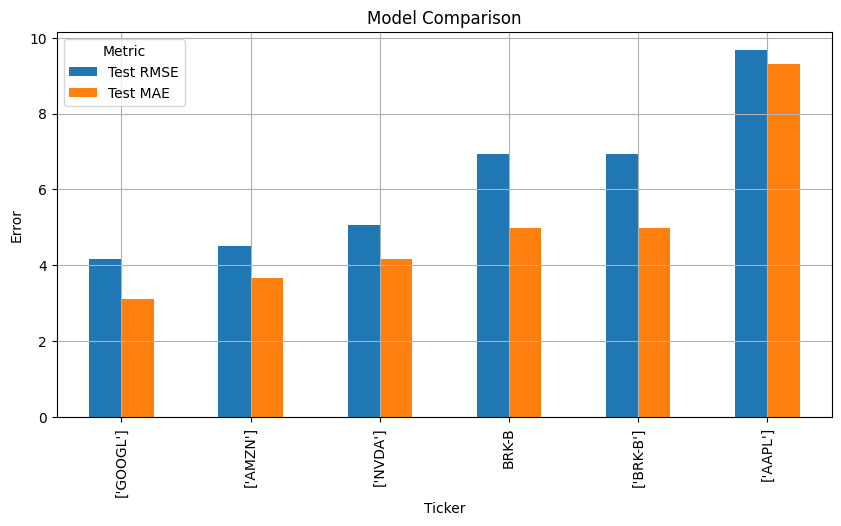

In [27]:
# 📈 Bar plot of RMSE and MAE
pivot_df[["Test RMSE", "Test MAE"]].plot(kind='bar', figsize=(10, 5), title="Model Comparison")
plt.ylabel("Error")
plt.grid(True)
plt.show()
